# AutoRegressive Moving Average (ARMA)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

register_matplotlib_converters()

In [2]:
# Read catfish sales data

catfish_sales = pd.read_csv("./data/catfish.csv", index_col=0, parse_dates=[0], date_format="%Y-%m-%d")

In [3]:
catfish_sales = catfish_sales.squeeze()

In [4]:
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [5]:
start_date = datetime(2000, 1, 1)
end_date = datetime(2004, 1, 1)
lim_catfish_sales = catfish_sales[start_date:end_date]

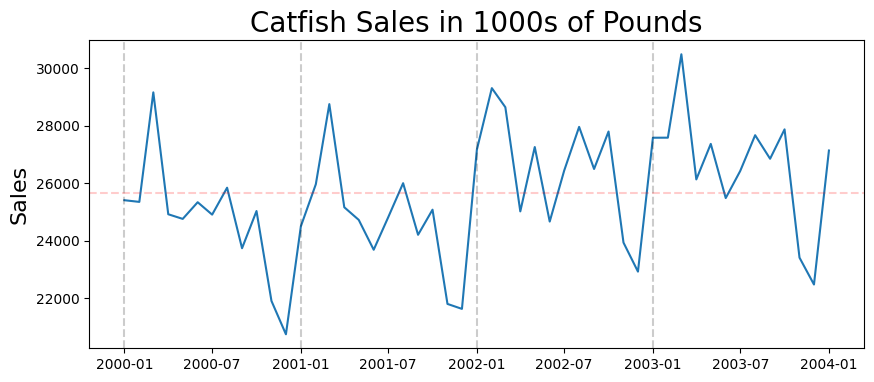

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(lim_catfish_sales)
plt.title("Catfish Sales in 1000s of Pounds", fontsize=20)
plt.ylabel("Sales", fontsize=16)
for year in range(2000, 2004):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)

plt.axhline(lim_catfish_sales.mean(), color='r', linestyle='--', alpha=0.2)

In [7]:
first_diff = lim_catfish_sales.diff()[1:]

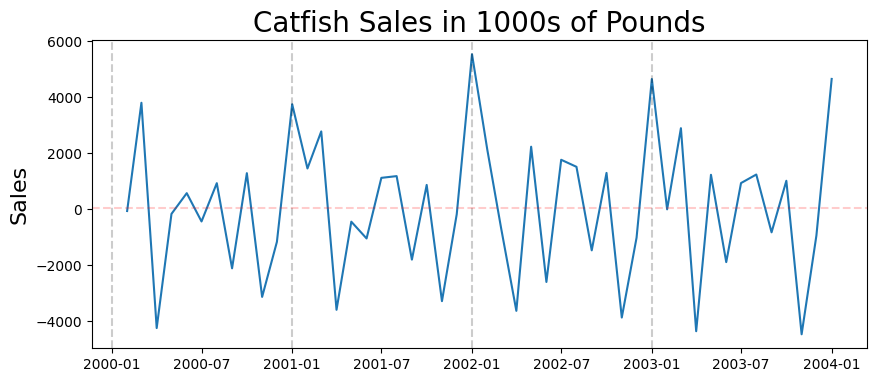

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(first_diff)
plt.title("Catfish Sales in 1000s of Pounds", fontsize=20)
plt.ylabel("Sales", fontsize=16)
for year in range(2000, 2004):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)

plt.axhline(first_diff.mean(), color='r', linestyle='--', alpha=0.2)

## Get ACF and PACF to inform what order of MA and AR for the model respectively

Text(0.5, 1.0, 'ACF')

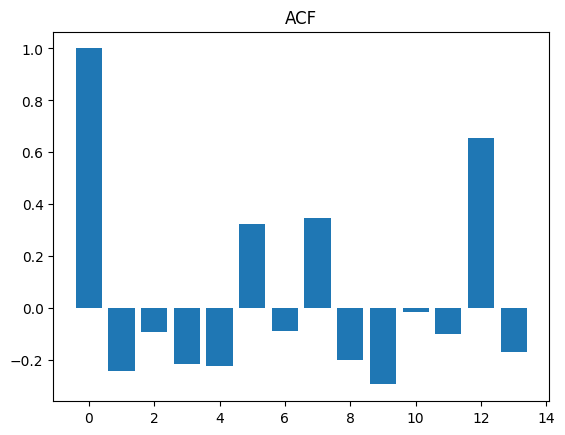

In [12]:
num_lags = 14
acf_vals = acf(first_diff)
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.title("ACF")

Text(0.5, 1.0, 'PACF')

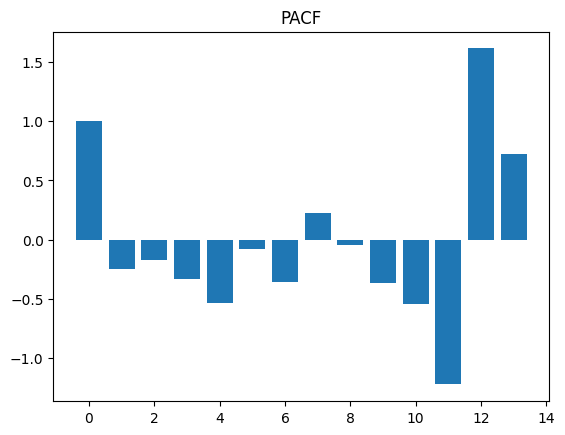

In [13]:
pacf_vals = pacf(first_diff)
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title("PACF")

From the video, ritvik chose MA(1) because the ACF showed a strong 1st lag and dropped off a bit until 5, so we just got for 1 as a starting point. Then he chose an AR(4) model because the PACF shows a strong lag at 4 which is the strongest lag until really far away values like 11 and 12. The 11 and 12 lags shows a seasonal/yearly pattern which will be covered in the SARIMA model.

In [14]:
train_end = datetime(2003, 7, 1)
test_end = datetime(2004, 1, 1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

In [17]:
# Fit ARMA model

model = ARIMA(train_data, order=(4, 0, 1)) # set order of I to 0 for it to be ARMA

In [19]:
start = time.time()
arma_model = model.fit()
end = time.time()
print(f"Trained model in: {end - start}")

Trained model in: 0.06742048263549805


In [21]:
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -376.598
Date:                Sun, 15 Sep 2024   AIC                            767.195
Time:                        10:21:05   BIC                            779.359
Sample:                    02-01-2000   HQIC                           771.654
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1795    179.935      0.134      0.893    -328.487     376.847
ar.L1         -0.8659      0.222     -3.896      0.000      -1.302      -0.430
ar.L2         -0.4234      0.246     -1.724      0.0

From the summary we see the P values for each of the parameters of the models. We typically only want to keep the ones with a P value that is <= 0.05, as any values greater than that suggest that the parameter is not significant to the model. 

Our summary result is quite different from the video, our ar.L2 and ar ar.L3 seems to not be significant and our ma.L1 is barely significant.

The model used in the video is $\hat{y_t} = -0.87y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

However, in our case, since the ar.L2 and ar.L3 are not significant we will not include those in our models. Thus our final model is:
$\hat{y_t} = -0.87y_{t-1} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [22]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [23]:
predictions = arma_model.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

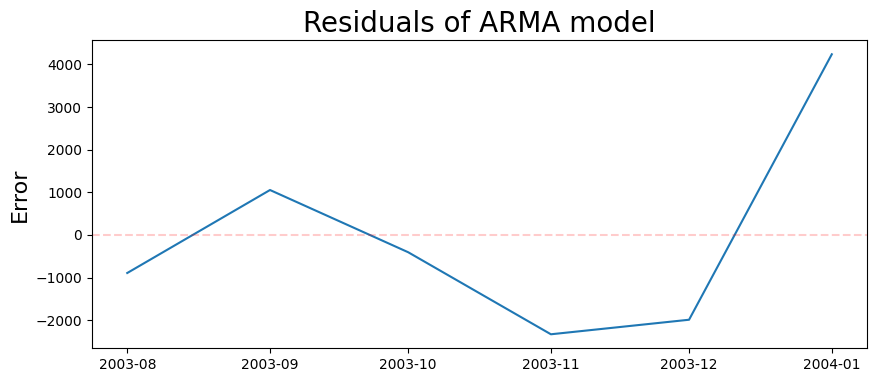

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals of ARMA model", fontsize=20)
plt.ylabel("Error", fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

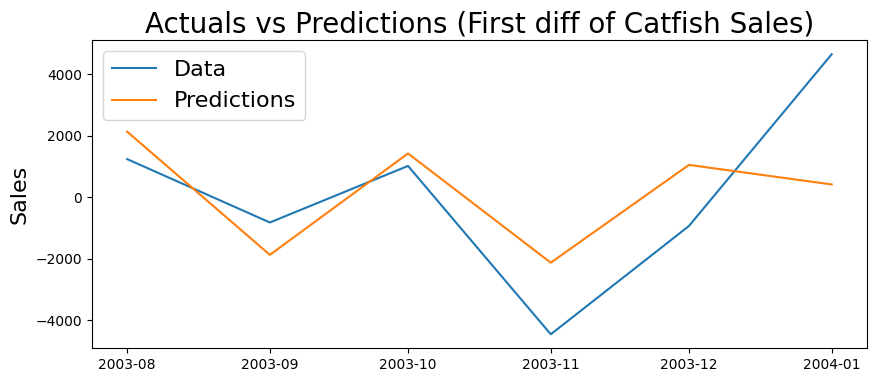

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title("Actuals vs Predictions (First diff of Catfish Sales)", fontsize=20)
plt.ylabel("Sales", fontsize=16)

In [27]:
print(f"Root mean square: {np.sqrt(np.mean(residuals**2))}")

Root mean square: 2214.6996890692794


Model seems to follow the general pattern but seems to have a lot of gaps which shows the model not being very good.